In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [2]:
from IPython.display import Audio
Audio('groove.mp3')


In [3]:
import torchaudio
audio, sr = torchaudio.load('./groove.mp3')

In [4]:
sr


44100

In [5]:
print(audio.shape)
audio = audio[0]


torch.Size([2, 266112])


In [6]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 6.034285714285715 seconds


In [7]:
audio

tensor([ 0.0000e+00, -3.7016e-12, -2.3931e-12,  ..., -5.1691e-07,
         1.4492e-06, -7.2987e-07])

In [8]:

def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

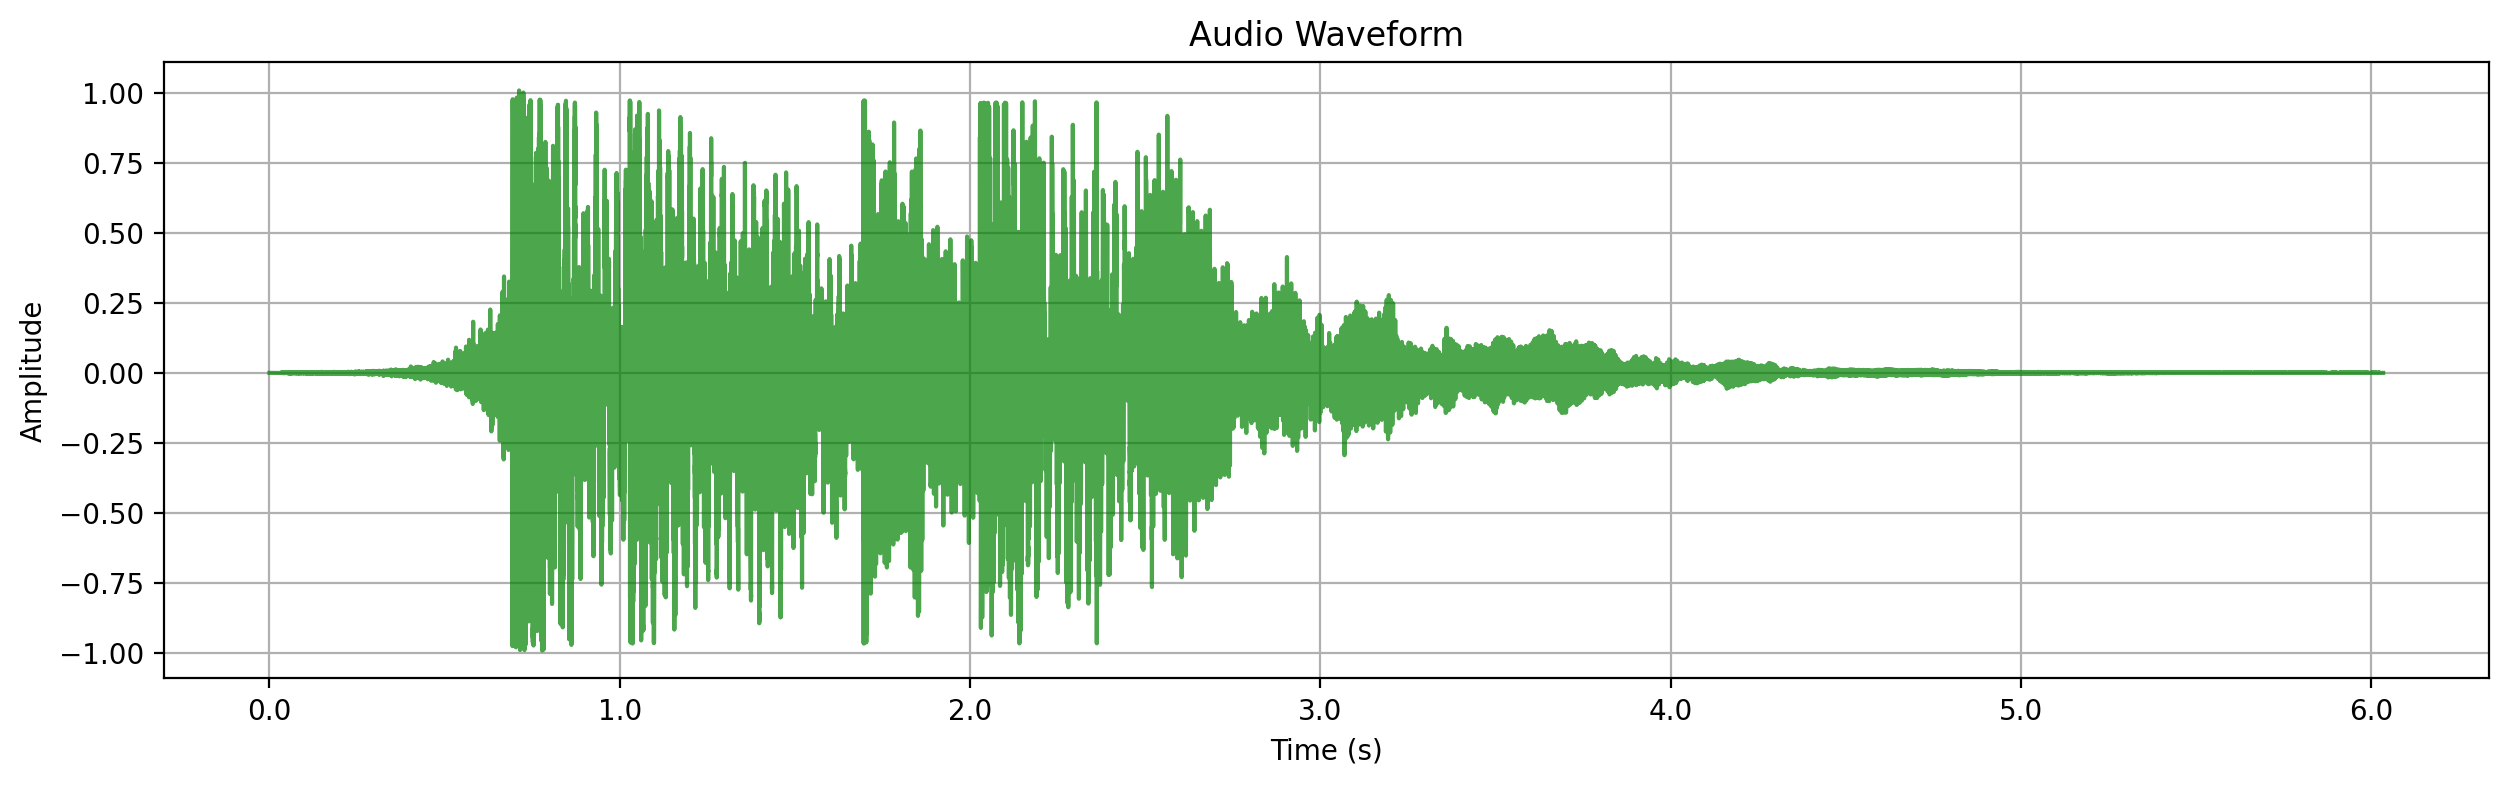

In [9]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [10]:
start_time = 0.5
end_time = 5.5


start_index = int(start_time * sr)
end_index = int(end_time * sr)


audio = audio[start_index:end_index]


print(audio.shape)
print(audio)

torch.Size([220500])
tensor([-5.8614e-03,  3.7020e-03,  1.1542e-02,  ...,  5.6923e-05,
         2.7782e-05,  1.4971e-04])


In [11]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [12]:
Audio(audio, rate = sr)

In [13]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [14]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0074, -0.0186, -0.0190,  ..., -0.0197,  0.0080, -0.0069],
        [ 0.0058, -0.0191, -0.0190,  ..., -0.0197,  0.0088, -0.0083],
        ...,
        [-0.0103, -0.0194, -0.0145,  ...,  0.0059, -0.0014, -0.0125],
        [-0.0089, -0.0189, -0.0145,  ...,  0.0064, -0.0004, -0.0137],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


In [15]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [16]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [17]:
Audio(pred_audio, rate = sr)

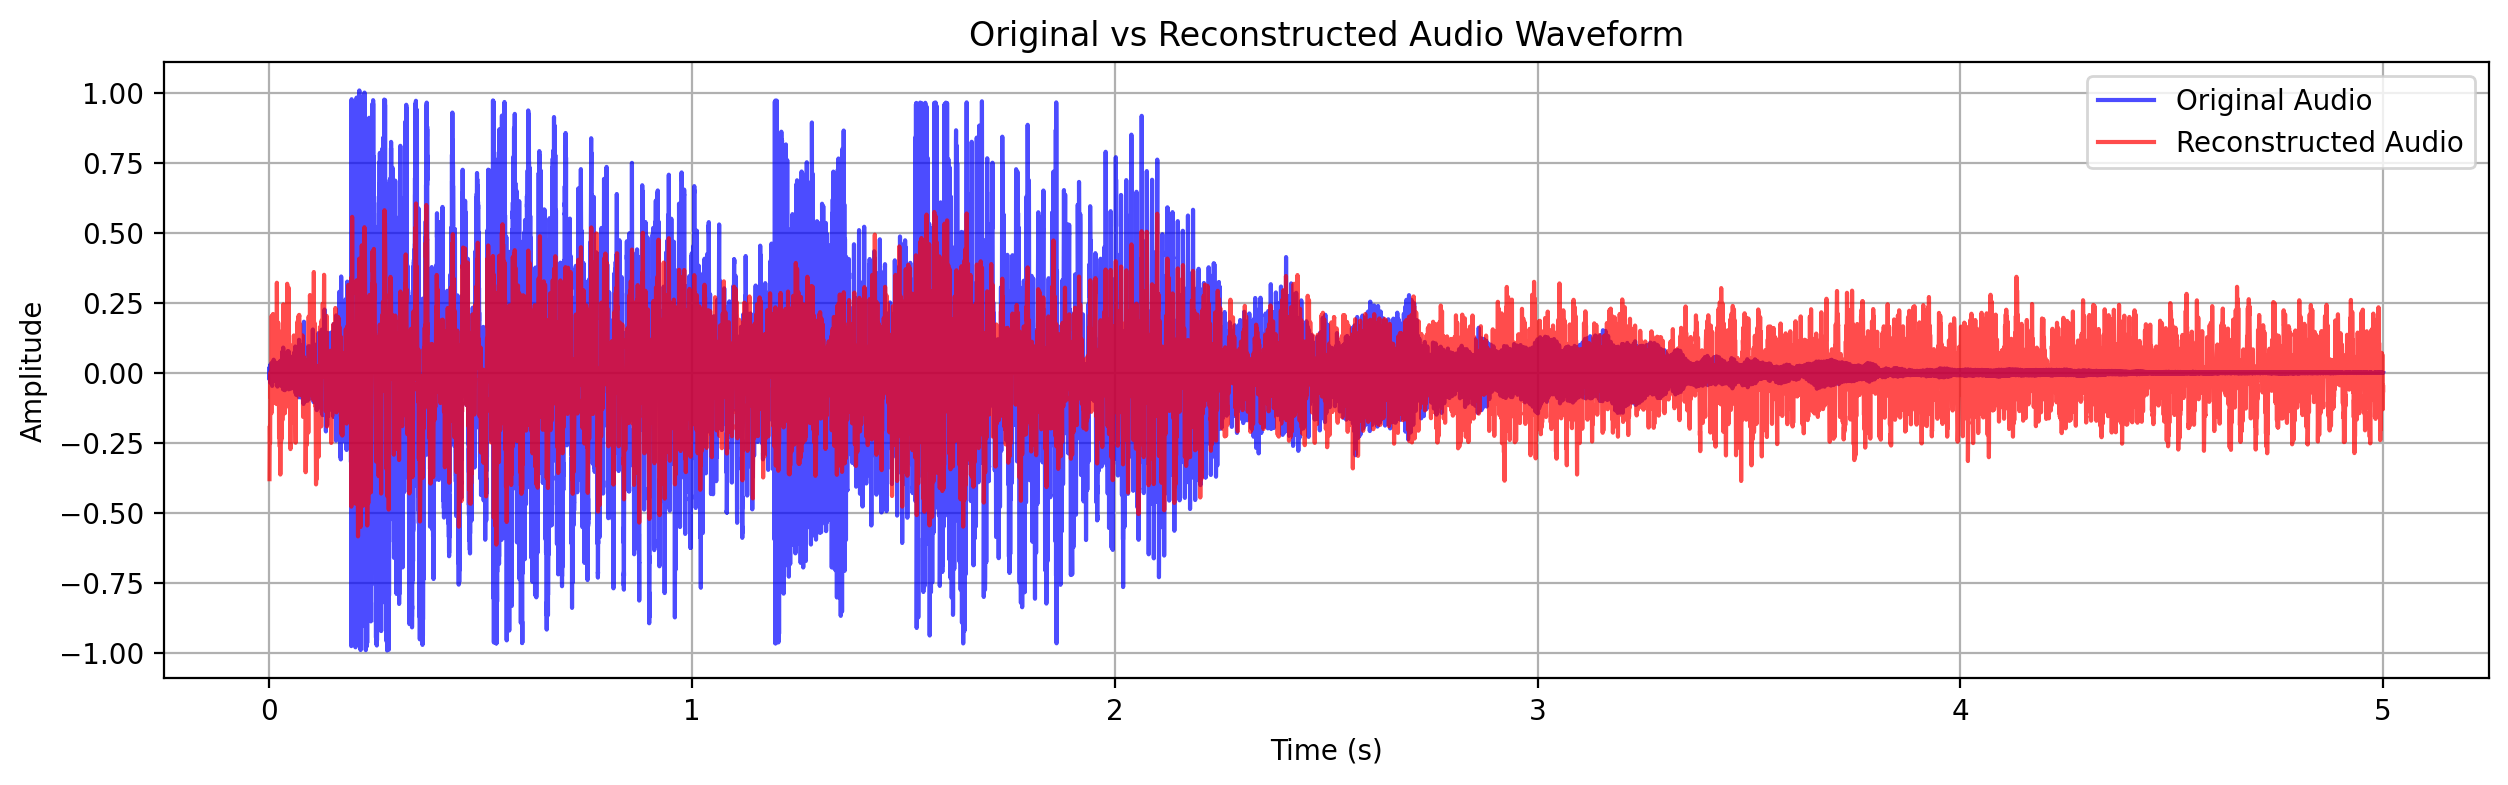

In [18]:
plt.figure(figsize=(15, 4))
time_axis = np.arange(audio.shape[0]) / sr
plt.plot(time_axis,audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(time_axis,pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [19]:

rmse = np.sqrt(np.mean((audio.numpy() - pred_audio) ** 2))

# Calculate SNR
signal_power = np.mean(audio.numpy() ** 2)
noise_power = np.mean((audio.numpy() - pred_audio) ** 2)
snr = 10 * np.log10(signal_power / noise_power)

print(f"RMSE: {rmse}")
print(f"SNR: {snr} dB")

RMSE: 0.16210559010505676
SNR: 2.5294455885887146 dB
